In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/human-faces-object-detection/faces.csv')

In [2]:
df.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [3]:
df.shape

(3350, 7)

In [4]:
for i in range(len(df)):
    print(list(df.iloc[i]))
    break
x0, y0, x1, y1 = list(df.iloc[0])[3:]
print(x0, x1, y0, y1)

['00001722.jpg', 1333, 2000, 490, 320, 687, 664]
490 687 320 664


(2000, 1333, 3)


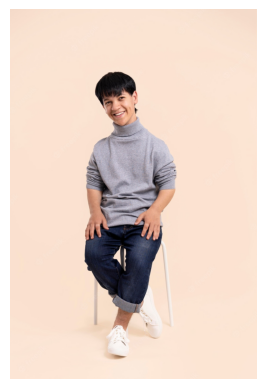

In [5]:
import cv2
import os
import matplotlib.pyplot as plt

img = os.path.join('/kaggle/input/human-faces-object-detection/images', df['image_name'][0])
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.axis('off')
plt.imshow(img)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),  # Resize images
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Custom dataset class
class FaceDataset(Dataset):
    def __init__(self, image_folder, df, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.data = self.load_data(df)

    def load_data(self, df):
        data = []
        for i in range(len(df)):
            parts = list(df.iloc[i])
            x0, y0, x1, y1 = parts[3:]
            img_path = os.path.join(self.image_folder, parts[0])
            bbox = list(map(float, [x0, y0, x1 - x0, y1 - y0]))  # x, y, width, height
            data.append((img_path, bbox))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, bbox = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bbox = torch.tensor(bbox, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, bbox

# Load dataset
dataset = FaceDataset(image_folder="/kaggle/input/human-faces-object-detection/images", df=df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [7]:
class FaceDetectionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # Output: (x, y, width, height)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Initialize model
model = FaceDetectionCNN()

In [8]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()  # Regression loss for bounding boxes
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in dataloader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete!")


Epoch 1/10, Loss: 12656843.9922
Epoch 2/10, Loss: 12037393.3853
Epoch 3/10, Loss: 11440727.8145
Epoch 4/10, Loss: 11323593.5137
Epoch 5/10, Loss: 10861308.7266
Epoch 6/10, Loss: 10336286.1621
Epoch 7/10, Loss: 9394560.7490
Epoch 8/10, Loss: 8612036.6182
Epoch 9/10, Loss: 7736800.2979
Epoch 10/10, Loss: 7126820.8857
Training complete!


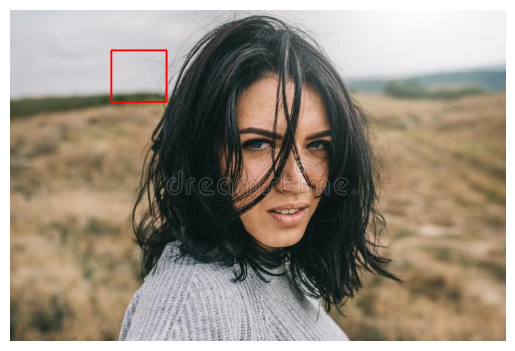

In [9]:
import matplotlib.pyplot as plt

def test_model(image_path):
    model.eval()
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (128, 128))
    image_tensor = transform(image_resized).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(image_tensor).cpu().numpy()[0]  # (x, y, width, height)
    
    x, y, w, h = map(int, prediction)
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

# Test on a sample image
test_model("/kaggle/input/human-faces-object-detection/images/00000018.jpg")
